In [351]:
# %load synimagegen.py
from typing import List, Tuple, Optional, Union
import numpy as np
from scipy.special import erf
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
%matplotlib inline

"""This module generates synthetic images for OpenPIV """

__licence_ = """
Copyright (C) 2011  www.openpiv.net

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANy WARRANTy; without even the implied warranty of
MERCHANTABILITy or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

you should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


In [352]:

def synthetic_flow_data(
    x: np.array,
    y: np.array
    )->Tuple[np.array, np.array]:
    """ Create a synthetic flow data on a discrete grid

    Args:
        x (np.array): 2D array
        y (np.array): 2D array

    Returns:
        Tuple(np.array, np.array): (u,v) on a fixed grid (x,y)
    """
    if np.min(np.r_[np.atleast_2d(x).shape, np.atleast_2d(y).shape]) < 2:
        raise ValueError("Expecting 2D x,y, use np.meshgrid ")
    
    u = 2.5 + 0.5 * np.sin((x**2 + y**2) / 0.01)
    v = 0.5 + 0.1 * np.cos((x**2 + y**2) / 0.01)
    return u,v


In [353]:
def continuous_flow_field(
    x: np.array,
    y: np.array,
    u: np.array,
    v:np.array
    )->Tuple:
    """_summary_

    Args:
        x (_type_): _description_
        y (_type_): _description_
        u (_type_): _description_
        v (_type_): _description_

    Returns:
        List of two interpolants: _description_
    """
    
    f_u = interp2d(x, y, u)
    f_v = interp2d(x, y, v)
    
    return f_u, f_v


In [354]:
def plot_synthetic_field_example():
    """ Plot an example of a synthetic flow field 
    
    """
    
    x = np.linspace(-2*np.pi,2*np.pi,10)
    y = np.linspace(-2*np.pi,2*np.pi,12)
    xx,yy = np.meshgrid(x,y)
    u,v = synthetic_flow_data(xx,yy)
    
    # continuous field
    x1 = np.linspace(-2*np.pi,2*np.pi,15)
    y1 = np.linspace(-2*np.pi,2*np.pi,21)
    f_u, f_v = continuous_flow_field(x,y,u,v)
    u1 = f_u(x1, y1)
    v1 = f_v(x1, y1)

    
    s = np.sqrt(np.sum(u**2 + v**2))/10
    
    fig = plt.figure()
    plt.quiver(x,y,u,v,angles='uv', scale_units='xy', scale=s,color='r')
    plt.quiver(x1,y1,u1,v1,angles='uv', scale_units='xy', scale=s, color='b')
    

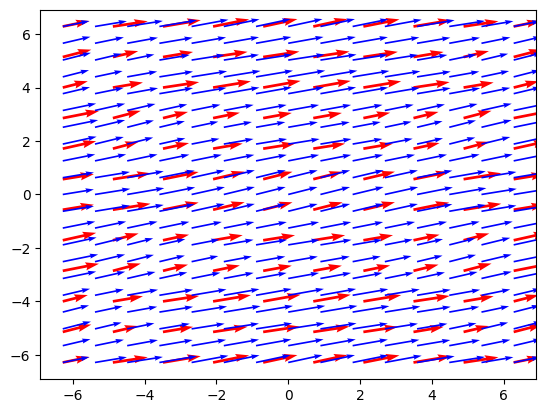

In [355]:
plot_synthetic_field_example()

In [356]:
def create_synimage_parameters(
    x, 
    y, 
    u, 
    v,
    image_size: Tuple[int, int] = (256, 256),
    particle_density: float = 0.008,
    per_loss_pairs: int = 5,
    par_diam_mean: float = 3.87,
    par_diam_std: float = 1.5,
    par_int_std: float = 0.25,
    dt: float = 0.1,
) -> Tuple:
    """Creates the synthetic image with the synthetic image parameters

    Parameters
    ----------
    input_data: None or numpy array or path to the file
        If you have data from which to genrate the flow feild the synthetic image.
        It should be passed on as a numpy array with columns being (x grid position,y grid position,U velocity at (x,y) grid point,V velocity at (x,y) grid point)

        Else, pass None and define a synthetic flow field in ContinousFlowField class.


    x_bound,y_bound: list/tuple of floats
        The boundries of interest in the synthetic flow field.

    image_size: list/tuple of ints
        The desired image size in pixels.

    particle_density: float
        Defines the number of particles per image.

    per_loss_pairs: float
        Percentage of synthetic pairs loss.

    par_diam_mean: float
        Mean particle diamter in pixels.

    par_diam_std: float
        Standard deviation of particles diamter in pixels.

    par_int_std: float
        Standard deviation of particles intensities.

    dt: float
        Synthetic time difference between both images.

    Returns
    -------
    ground_truth: ContinousFlowField class
        The synthetic ground truth as a ContinousFlowField class.

    cv:
        Convertion value to convert U,V from pixels/images to meters/seconds.

    x_1,y_1: numpy array
        Position of particles in the first synthetic image.

    u_par,v_par: numpy array
        Velocity speeds for each particle.

    par_diam1: numpy array
        Particle diamters for the first synthetic image.

    par_int1: numpy array
        Particle intensities for the first synthetic image.

    x_2,y_2: numpy array
        Position of particles in the second synthetic image.

    par_diam2: numpy array
        Particle diamters for the second synthetic image.

    par_int2: numpy array
        Particle intensities for the second synthetic image.
    """



    # Creating syn particles

    n_particles = int(image_size[0] * image_size[1] * particle_density)
    num_of_lost_pairs = n_particles * (per_loss_pairs / 100)
    
    # distribute particles in the flow
    f_u, f_v = continuous_flow_field(x,y,u,v)
    
    x_bound = [np.min(x), np.max(x)]
    y_bound = [np.min(y), np.max(y)]

       
    x_1 = np.random.uniform(x_bound[0] * 0.8, x_bound[1] * 1.2, n_particles)
    y_1 = np.random.uniform(y_bound[0] * 0.8, y_bound[1] * 1.2, n_particles)
    par_diam1 = np.random.normal(par_diam_mean, par_diam_std, n_particles)
    particle_centers = np.random.uniform(size=n_particles) - 0.5
    par_int1 = np.exp(-(particle_centers**2) / (2 * par_int_std**2))
    
    # assign them velocities
    u_par = f_u(x_1, y_1)
    v_par = f_v(x_1, y_1)
    
    # shift particles to the second image
    x_2 = x_1 + u_par*dt
    y_2 = y_1 + v_par*dt
    
    # copy the particle parameters to the second image
    par_diam2 = par_diam1.copy()
    par_int2 = par_int1.copy()
    
    # Now loose some pairs by selecting a sub-sample
    par_diam2 = np.random.choice(par_diam2, n_particles - num_of_lost_pairs)
    par_int2 = np.random.choice(par_int2, n_particles - num_of_lost_pairs)
    
    # add some new randomly located particles
    x_3 = np.random.uniform(x_bound[0] * 0.8, x_bound[1] * 1.2, num_of_lost_pairs)
    y_3 = np.random.uniform(y_bound[0] * 0.8, y_bound[1] * 1.2, num_of_lost_pairs)
    par_diam3 = np.random.normal(par_diam_mean, par_diam_std, num_of_lost_pairs)
    particle_centers = np.random.uniform(size=num_of_lost_pairs) - 0.5
    par_int3 = np.exp(-(particle_centers**2) / (2 * par_int_std**2))
    
    
    x_2 = np.concatenate([x_2, x_3])
    y_2 = np.concatenate([y_2, y_3])
    par_diam2 = np.concatenate([par_diam2, par_diam3])
    par_int2 = np.concatenate([par_int2, par_int3])
    
    xy_1 = np.transpose(np.vstack((x_1, y_1, par_diam1, par_int1)))
    xy_2 = np.transpose(np.vstack((x_2, y_2, par_diam2, par_int2)))

    # Choosing particles inside boundary area

    bounded_xy_1 = np.asarray(
        [
            xy
            for xy in xy_1
            if x_bound[1] >= xy[0] >= x_bound[0] and y_bound[1] >= xy[1] >= y_bound[0]
        ]
    )
    bounded_xy_2 = np.asarray(
        [
            xy
            for xy in xy_2
            if x_bound[1] >= xy[0] >= x_bound[0] and y_bound[1] >= xy[1] >= y_bound[0]
        ]
    )

    # Tranforming coordinates into pixels

    x1 = ((bounded_xy_1[:, 0] - x_bound[0]) / (x_bound[1] - x_bound[0])) * image_size[0]
    y1 = ((bounded_xy_1[:, 1] - y_bound[0]) / (y_bound[1] - y_bound[0])) * image_size[1]

    x2 = ((bounded_xy_2[:, 0] - x_bound[0]) / (x_bound[1] - x_bound[0])) * image_size[0]
    y2 = ((bounded_xy_2[:, 1] - y_bound[0]) / (y_bound[1] - y_bound[0])) * image_size[1]

    conversion_value = (
        min(
            (x_bound[1] - x_bound[0]) / image_size[0],
            (y_bound[1] - y_bound[0]) / image_size[1],
        )
        / dt
    )

    return (
        x1,
        y1,
        x2,
        y2,
        conversion_value,
    )


In [357]:
# invent some region
x,y = np.linspace(0,1), np.linspace(1,2)
# make it 2D:
x,y = np.meshgrid(x,y)
# create velocity field for those grid points
u,v = synthetic_flow_data(x,y)
# stack data
data = np.stack([x,y,u,v],axis=2)


In [358]:

# create synthetic particle positions, diameters, etc. 
def create_synimage_parameters(
    x,
    y, 
    u, 
    v, 
    image_size = (64,64),
    particle_density = 0.1,
    per_loss_pairs = 5,
    par_diam_mean = 3.87,
    par_diam_std = 1.5,
    par_int_std = 0.25,
    dt = 0.1,
    ):



    # Creating syn particles

    n_particles = int(image_size[0] * image_size[1] * particle_density)
    num_of_lost_pairs = int(np.round(n_particles * (per_loss_pairs / 100)))

    # distribute particles in the flow
    f_u, f_v = continuous_flow_field(x,y,u,v)

    x_bound = [np.min(x), np.max(x)]
    y_bound = [np.min(y), np.max(y)]

    from numpy.random import default_rng
    rng = default_rng()
        
    x_1 = rng.uniform(x_bound[0] * 0.8, x_bound[1] * 1.2, n_particles)
    y_1 = rng.uniform(y_bound[0] * 0.8, y_bound[1] * 1.2, n_particles)
    par_diam1 = rng.normal(par_diam_mean, par_diam_std, n_particles)
    particle_centers = rng.uniform(size=n_particles) - 0.5
    par_int1 = np.exp(-(particle_centers**2) / (2 * par_int_std**2))

    # assign them velocities
    u_par = np.array([f_u(a, b) for (a,b) in zip(x_1,y_1)])
    v_par = np.array([f_v(a, b) for (a,b) in zip(x_1,y_1)])

    # shift particles to the second image
    x_2 = x_1 + u_par[:,0]*dt
    y_2 = y_1 + v_par[:,0]*dt

    # copy the particle parameters to the second image
    par_diam2 = par_diam1.copy()
    par_int2 = par_int1.copy()

    plt.figure()
    plt.scatter(x_1, y_1)
    plt.scatter(x_2, y_2, color='r')
    plt.quiver(x_1, y_1, u_par, v_par)


    # Now loose some pairs by selecting a sub-sample
    lost = rng.choice(range(n_particles),num_of_lost_pairs)


    # add some new randomly located particles
    x_3 = rng.uniform(x_bound[0] * 0.8, x_bound[1] * 1.2, num_of_lost_pairs)
    y_3 = rng.uniform(y_bound[0] * 0.8, y_bound[1] * 1.2, num_of_lost_pairs)
    par_diam3 = rng.normal(par_diam_mean, par_diam_std, num_of_lost_pairs)
    particle_centers = rng.uniform(size=num_of_lost_pairs) - 0.5
    par_int3 = np.exp(-(particle_centers**2) / (2 * par_int_std**2))


    x_2[lost] = x_3
    y_2[lost] = y_3
    par_diam2[lost] = par_diam3
    par_int2[lost] = par_int3

    xy_1 = np.transpose(np.vstack((x_1, y_1, par_diam1, par_int1)))
    xy_2 = np.transpose(np.vstack((x_2, y_2, par_diam2, par_int2)))

    print(xy_1.shape, xy_2.shape)
    
    # Choosing particles inside boundary area

    bounded_xy_1 = np.asarray(
        [
            xy
            for xy in xy_1
            if x_bound[1] >= xy[0] >= x_bound[0] and y_bound[1] >= xy[1] >= y_bound[0]
        ]
    )
    bounded_xy_2 = np.asarray(
        [
            xy
            for xy in xy_2
            if x_bound[1] >= xy[0] >= x_bound[0] and y_bound[1] >= xy[1] >= y_bound[0]
        ]
    )

    # Tranforming coordinates into pixels

    x1 = ((bounded_xy_1[:, 0] - x_bound[0]) / (x_bound[1] - x_bound[0])) * image_size[0]
    y1 = ((bounded_xy_1[:, 1] - y_bound[0]) / (y_bound[1] - y_bound[0])) * image_size[1]

    x2 = ((bounded_xy_2[:, 0] - x_bound[0]) / (x_bound[1] - x_bound[0])) * image_size[0]
    y2 = ((bounded_xy_2[:, 1] - y_bound[0]) / (y_bound[1] - y_bound[0])) * image_size[1]

    conversion_value = (
        min(
            (x_bound[1] - x_bound[0]) / image_size[0],
            (y_bound[1] - y_bound[0]) / image_size[1],
        )
        / dt
    )

    return x1 , y1, bounded_xy_1[:,2], bounded_xy_1[:,3], x2, y2, bounded_xy_2[:,2], bounded_xy_2[:,3]

(409, 4) (409, 4)


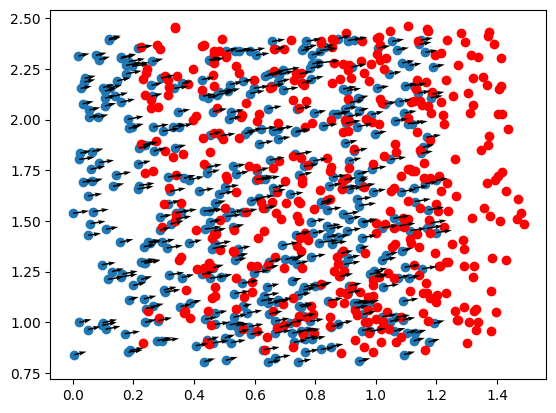

In [359]:
x1 , y1, par_diam1, par_int1, x2, y2, par_diam2, par_int2 = \
create_synimage_parameters(
    x,
    y, 
    u, 
    v, 
    image_size = (64,64),
    particle_density = 0.1,
    per_loss_pairs = 5,
    par_diam_mean = 3.87,
    par_diam_std = 1.5,
    par_int_std = 0.25,
    dt = 0.1,
    )

In [360]:
def generate_particle_image(
    height: int,
    width: int,
    x: np.array,
    y: np.array,
    particle_diameters: np.array,
    particle_max_intensity: float,
    bit_depth: int = 8,
):
    """Creates the synthetic image with the synthetic image parameters
    Should be run with the parameters of each image (first,second) separately.

    Parameters
    ----------
    height, width: int
        The number of pixels in the desired output image.

    x,y: numpy array
        The x and y positions of the particles, created by create_synimage_parameters().

    particle_diameters, particle_max_intensity: numpy array
                The intensities and diameters of the particles, created by create_synimage_parameters().

        bit_depth: int
                The bit depth of the desired output image.

    Returns
    -------
    Image: numpy array
        The desired synthetic image.

    """
    render_fraction = 0.75
    sqrt8 = np.sqrt(8)

    image_out = np.zeros([height, width])

    minRenderedCols = (x - render_fraction * particle_diameters).astype(int)
    maxRenderedCols = (np.ceil(x + render_fraction * particle_diameters)).astype(int)
    minRenderedRows = (y - render_fraction * particle_diameters).astype(int)
    maxRenderedRows = (np.ceil(y + render_fraction * particle_diameters)).astype(int)

    index_to_render = []

    for i in range(x.size):
        if (
            1 < minRenderedCols[i]
            and maxRenderedCols[i] < width
            and 1 < minRenderedRows[i]
            and maxRenderedRows[i] < height
        ):
            index_to_render.append(i)

    for ind in index_to_render:
        max_int = particle_max_intensity[ind]
        par_diam = particle_diameters[ind]

        bl = max(minRenderedCols[ind], 0)
        br = min(maxRenderedCols[ind], width)
        bu = max(minRenderedRows[ind], 0)
        bd = min(maxRenderedRows[ind], height)

        for c in range(bl, br):
            for r in range(bu, bd):
                image_out[r, c] = image_out[
                    r, c
                ] + max_int * par_diam**2 * np.pi / 32 * (
                    erf(sqrt8 * (c - x[ind] - 0.5) / par_diam)
                    - erf(sqrt8 * (c - x[ind] + 0.5) / par_diam)
                ) * (
                    erf(sqrt8 * (r - y[ind] - 0.5) / par_diam)
                    - erf(sqrt8 * (r - y[ind] + 0.5) / par_diam)
                )

    noise_mean = 2 ** (bit_depth * 0.3)
    noise_std = 0.25 * noise_mean
    noise = noise_std * np.random.randn(height, width) + noise_mean
    return (image_out * (2**bit_depth * 2.8**2 / 8) + noise).astype(int)[::-1]


In [361]:
def generate_particle_images_pair(
    image_size, x1 , y1, par_diam1, par_int1, x2, y2, par_diam2, par_int2
):

    a = generate_particle_image(image_size[0], 
                                image_size[1],
                        x1 , y1, par_diam1, par_int1, 
                        8)
    b = generate_particle_image(image_size[0], 
                                image_size[1],
                                x2, y2, par_diam2, par_int2, 
                                8)
    return a, b 
        

In [362]:
a,b = generate_particle_images_pair([64,64], 
                                    x1 , y1, par_diam1, par_int1, 
                                    x2, y2, par_diam2, par_int2)

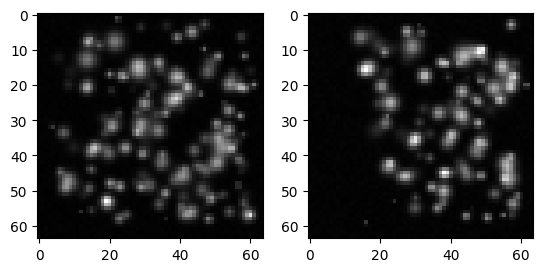

In [363]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(a, cmap='gray')
ax[1].imshow(b, cmap='gray')